## Get a dataset

In [ ]:
# Main variables
category_in_prompt = 'aircraft'
dataset_name = 'sun'
generation_tool = 'sdxl'
model_name = 'clip'
USE_GENERATED = True

# CHANGE WHEN SWITCHING DATASETS
from sun_classnames import label_to_class

In [ ]:
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient
from transformers import CLIPProcessor, CLIPModel


device = "cuda"

# Load the dataset
ds = load_dataset("clip-benchmark/wds_sun397")

print(ds)

dataset_split = 'test'

In [ ]:
from IPython.display import display,HTML
from PIL import Image

for row in ds[dataset_split]:
    with Image.open(row['webp']) as img:
	    display(img)

## Choose model for evaluation

In [ ]:
from transformers import FlavaProcessor, FlavaModel, FlavaFeatureExtractor, BertTokenizer
from open_clip import create_model_from_pretrained, get_tokenizer

# model = FlavaModel.from_pretrained("facebook/flava-full").cuda()
# image_processor = FlavaFeatureExtractor.from_pretrained("facebook/flava-full")
# text_processor = BertTokenizer.from_pretrained("facebook/flava-full")

model, image_processor = create_model_from_pretrained('hf-hub:timm/ViT-L-16-SigLIP-384')
text_processor = get_tokenizer('hf-hub:timm/ViT-L-16-SigLIP-384')

# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()
# image_processor = text_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


## Find all unique classes and generate embeddings

In [ ]:
from pymongo import MongoClient
import pickle

image_embeddings = {}
text_embeddings = {}

mongo_connection_string = ""
db_client = MongoClient(mongo_connection_string)
db_name = "data_experimental"
db = db_client[db_name]
collection = db["generated_datasets"]

def get_image_embedding(model, preprocessor, image):
    if model_name == 'siglip':
        image = preprocess(image).unsqueeze(0)
        image_embedding = model.encode_image(image)
    else:
        inputs = preprocessor(images=image, return_tensors="pt").to('cuda')
        with torch.no_grad():
            image_embedding = model.get_image_features(**inputs)
            if model_name in ['flava']:
                image_embedding = image_embedding[:, 0].float()
    image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
    return image_embedding.squeeze()  # Keep on CUDA

def get_text_embedding(model, preprocessor, text):
    if model_name == 'siglip':
        tokens = tokenizer(text, context_length=model.context_length)
        text_embedding = model.encode_text(tokens)
    inputs = preprocessor(text=text, return_tensors="pt").to('cuda')
    with torch.no_grad():
        text_embedding = model.get_text_features(**inputs)
        if model_name in ['flava']:
            text_embedding = text_embedding[:, 0].float()
    text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
    return text_embedding.squeeze()

class_tag = 'cls'
img_tag = 'jpg'

print(ds[dataset_split].features[class_tag])
num = 0 
for class_id, class_name in enumerate(label_to_class.keys() if category_in_prompt == 'nested' else label_to_class.values()):
    text_embeddings[class_name] = get_text_embedding(model, text_processor, f'a photo of {class_name.replace("_", " ")}')
    image_embeddings[class_name] = []

if not USE_GENERATED:
    for row in ds[dataset_split]:
        class_id = row[class_tag]
        class_name = label_to_class[class_id] if category_in_prompt == 'nested' else list(label_to_class.values())[class_id]
        image_embedding = get_image_embedding(model, image_processor, row[img_tag])
        image_embeddings[class_name].append(image_embedding)
        # collection.insert_one({
        #         'dataset': dataset_name,
        #         'generation_tool': 'real',
        #         'class_name': class_name.replace(" ", "-")[:100],
        #         'model': model_name,
        #         'num': None,
        #         'url': row['__url__'],
        #         'embedding': pickle.dumps(image_embedding),
        #     })

    class_means = {class_name: torch.mean(torch.stack(image_embeddings[class_name]), dim=0) for class_name in image_embeddings}
# for class_id, class_name in enumerate(label_to_class.keys() if category_in_prompt == 'nested' else label_to_class.values()):
#     print(class_id, class_name)
#     class_images = ds[dataset_split].filter(lambda x: x[class_tag] == class_id)
#     print(class_images)
#     if not USE_GENERATED:
#         image_embeddings[class_name] = [get_image_embedding(model, image_processor, image) for image in class_images[img_tag]]
#     text_embeddings[class_name] = get_text_embedding(model, text_processor, f'a photo of a {class_name.replace("_", " ")}')
    # num += 1
    # if num > 4:
    #     break



## optional: get class clusters if dataset is not fine grained

In [ ]:
# todo later
for class_name, images in image_embeddings.items():
    print(f"Class '{class_name}' has {len(images)} images")

## Choose generation tool

In [ ]:
import io
import torch
import openai
import urllib.request
from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel, EulerDiscreteScheduler
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file
from PIL import Image
import time
import threading

def initialize_sdxl():
    base = "stabilityai/stable-diffusion-xl-base-1.0"
    repo = "ByteDance/SDXL-Lightning"
    ckpt = "sdxl_lightning_4step_unet.safetensors"

    # Load model.
    unet = UNet2DConditionModel.from_config(base, subfolder="unet").to("cuda", torch.float16)
    unet.load_state_dict(load_file(hf_hub_download(repo, ckpt), device="cuda"))
    sdxl_pipe = StableDiffusionXLPipeline.from_pretrained(base, unet=unet, torch_dtype=torch.float16, variant="fp16").to("cuda")

    # Ensure sampler uses "trailing" timesteps.
    sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(sdxl_pipe.scheduler.config, timestep_spacing="trailing")
    return sdxl_pipe

# sdxl_pipe = None
# if generation_tool == 'sdxl':
#     sdxl_pipe = initialize_sdxl()

def blob_save(prompt, buf, num):
    current_time = round(time.time() * 1000)
    blob_name = f"photo-{dataset_name}-{prompt.replace(' ', '-')[:100]}-{generation_tool}-{num}"
    connect_str = ''
    blob_service_client = BlobServiceClient.from_connection_string(connect_str)
    container_name = 'will-clip-zero-shot'
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=f"{blob_name}.png")
    print(blob_name)
    print(blob_client.upload_blob(buf, overwrite=True))

    data = {
        "phrase": prompt,
        "image": f"https://.blob.core.windows.net/will-clip-zero-shot/{blob_name}.png",
        "created_at": current_time,
    }
    
    return data

def generate_image_sdxl(prompt, category=None):
    formatted_prompt = f'a realistic picture of a {category_in_prompt} containing a {prompt}'
    if category_in_prompt == 'nested' and category is not None:
        formatted_prompt = f'a realistic picture of a {category[:-1] if category[-1] == "s" else category} known as a {prompt}'
    print(formatted_prompt)
    image = sdxl_pipe(prompt=formatted_prompt).images[0]
    buf = io.BytesIO()
    image.save(buf, format='PNG')
    buf.seek(0)


client = openai.OpenAI(api_key="") #

def generate_image_dalle_single(prompt, i):
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size="1024x1024",
        quality="standard",
        response_format="url",
        style="natural"
    )
    print(response)

    for gen_image in response.data:
        with urllib.request.urlopen(gen_image.url) as url:
            img = Image.open(url)
            img.convert('RGBA')
            buf = io.BytesIO()
            img.save(buf, format='PNG')
            buf.seek(0)
            blob_save(class_name, buf, i)

def generate_image_dalle(prompt, category=None):
    global client
    formatted_prompt = f'a photo of a {category_in_prompt} known as a {prompt}'
    if category_in_prompt == 'nested' and category is not None:
        formatted_prompt = f'a photo of a {category[:-1] if category[-1] == "s" else category} known as a {prompt}'
    print(formatted_prompt)

    threads = []
    num_threads = 20

    # Start each thread
    for j in range(num_threads):
        thread = threading.Thread(target=generate_image_dalle_single, args=(formatted_prompt, j))
        threads.append(thread)
        thread.start()

    # Wait for all threads to finish
    for thread in threads:
        thread.join()

## Generate images for each class

In [ ]:
import time

generated_image_embeddings = {}





start = False
for class_name in label_to_class.keys() if category_in_prompt == 'nested' else label_to_class.values():
    generated_image_embeddings[class_name] = []
    print('images of:', class_name)
    if class_name == 'C-130':
        start = True
    else:
        continue
    if generation_tool == 'dalle3':
        category = label_to_class[class_name] if category_in_prompt == 'nested' else None
        generated_image = generate_image_dalle(class_name, category)
    else:
        for i in range(20):
            if generation_tool == 'sdxl':
                category = label_to_class[class_name] if category_in_prompt == 'nested' else None
                generated_image = generate_image_sdxl(class_name, category)
            else:
                raise Exception('Unsupported generation')
            
        # generated_image_embeddings[class_name].append(get_image_embedding(model, image_processor, Image.open(generated_image)))

# class_means = {class_name: torch.mean(torch.stack(generated_image_embeddings[class_name]), dim=0) for class_name in generated_image_embeddings}

## Or download previously generated images

In [ ]:
from pymongo import MongoClient
import pickle
import urllib.request
from PIL import Image
import json

generated_image_embeddings = {}

mongo_connection_string = ""
db_client = MongoClient(mongo_connection_string)
db_name = "data_experimental"
db = db_client[db_name]
collection = db["generated_datasets"]

for class_name in label_to_class.values():
    generated_image_embeddings[class_name] = []
    
    print('images of:', class_name)
    for i in range(20):
        blob_name = f'photo-{dataset_name}-{class_name.replace(" ", "-")[:100]}-{generation_tool}-{i}'
        blob_url = f"https://.blob.core.windows.net/will-clip-zero-shot/{blob_name}.png"
        print(blob_url)
        with urllib.request.urlopen(blob_url) as url:
            embedding = get_image_embedding(model, image_processor, Image.open(url).resize((1024, 1024)))
            generated_image_embeddings[class_name].append(embedding)
            # put image embedding in db with link to pic
            # collection.insert_one({
            #     'dataset': dataset_name,
            #     'generation_tool': generation_tool,
            #     'class_name': class_name.replace(" ", "-")[:100],
            #     'model': model_name,
            #     'num': i,
            #     'url': blob_url,
            #     'embedding': pickle.dumps(embedding),
            #     'size': 1024
            # })

class_means = {class_name: torch.mean(torch.stack(generated_image_embeddings[class_name]), dim=0) for class_name in generated_image_embeddings}


In [ ]:
import json
from pymongo import MongoClient
import torch
import io
import pickle

# dataset_name = 'aircraft'
# generation_tool = 'dalle3' # or sdxl

generated_image_embeddings = {}

for class_name in label_to_class.values():
    generated_image_embeddings[class_name.replace(' ', '-')] = []

mongo_connection_string = ""
db_client = MongoClient(mongo_connection_string)
db_name = "data_experimental"
db = db_client[db_name]
collection = db["generated_datasets"]
results = collection.find(
    {
        'model': model_name,
        'dataset': dataset_name,
        'generation_tool': generation_tool if USE_GENERATED else 'real'
    },
    {
        '_id': 0,
        'dataset': 1, 
        'class_name': 1,
        'model': 1,
        'url': 1,
        'embedding': 1
    }
)
results = list(results)
print(len(list(results)))

for row in results:
    generated_image_embeddings[row['class_name']].append(pickle.loads(row['embedding']))


print(results[0])
binary_embedding = results[0]['embedding']
# Deserialize the binary data back into a PyTorch tensor
embedding_tensor = pickle.loads(binary_embedding)
print(embedding_tensor)

class_means = {class_name: torch.mean(torch.stack(generated_image_embeddings[class_name.replace(' ', '-')]), dim=0) for class_name in generated_image_embeddings}

## Evaluate zero-shot accuracy

In [ ]:
def calculate_zero_shot_accuracy(class_name, embeddings):
    correct_predictions = 0
    total_predictions = len(embeddings[class_name])

    for I_k in embeddings[class_name]:
        # Calculate cosine similarities between image embedding and each class's text embedding
        similarities = [torch.nn.functional.cosine_similarity(I_k.unsqueeze(0), text_embeddings[cname].unsqueeze(0)).item()
                        for cname in text_embeddings]
        # Find the class with the highest similarity
        predicted_class_index = similarities.index(max(similarities))
        predicted_class = list(text_embeddings.keys())[predicted_class_index]
        print(predicted_class, class_name)
        # Check if the prediction is correct
        if predicted_class == class_name:
            correct_predictions += 1
    print(class_name, correct_predictions / total_predictions)
    return correct_predictions / total_predictions

## Evaluate consistency scores
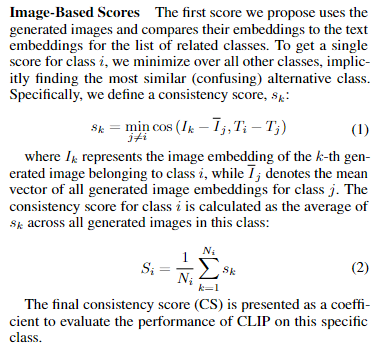

In [ ]:
# def calculate_consistency_score(image_embeddings, class_means, text_embeddings, target_class):
#     s_k_scores = []
#     target_text_embedding = text_embeddings[target_class]
#     mean_i = class_means
#     target_class_images = torch.stack([torch.tensor(img) for img in image_embeddings[target_class]])

#     for I_k in target_class_images:
#         similarities = []
#         min_3_similarities = [2,2,2]
#         for j, mean_j in class_means.items():
#             if j != target_class:
#                 diff_image_vector = I_k - mean_j
#                 diff_text_vector = target_text_embedding - text_embeddings[j]

#                 similarity = torch.nn.functional.cosine_similarity(diff_image_vector.unsqueeze(0), diff_text_vector.unsqueeze(0)).item()
#                 # if similarity < max(min_3_similarities):
#                 #     min_3_similarities.remove(max(min_3_similarities))
#                 #     min_3_similarities.append(similarity)
#                 similarities.append(similarity)
#         average = sum(similarities) / len(similarities)
#         s_k_scores.append(min(similarities))
#         # s_k_scores.append(min(similarities))

#     # Return the average consistency score S_i for the class
#     S_i = torch.tensor(s_k_scores).mean().item()
#     return S_i

def calculate_consistency_score(image_embeddings, class_means_image, text_embeddings, target_class):
    # Convert lists of embeddings to tensors for the target class
    target_class_images = torch.stack([torch.tensor(img) for img in image_embeddings[target_class]])
    target_class_mean_image = class_means_image[target_class]

    # Calculate intra-class compactness (C_i) for the image space
    # C_i_image = torch.mean(torch.norm(target_class_images - target_class_mean_image, p=2, dim=1)).item()
    C_i_image = torch.mean(torch.tensor([
        1 - torch.nn.functional.cosine_similarity(I_k.unsqueeze(0), target_class_mean_image.unsqueeze(0)).item()
        for I_k in target_class_images
    ])).item()

    # Intra-class compactness for text space is zero, since each class has a single text embedding
    C_i_text = 0

    k = 10
    # Calculate inter-class separability (D_i) using cosine distance in the image space
    D_i_image_list = []
    for j, embedding_j in class_means_image.items():
        if j != target_class:
            distance = 1 - torch.nn.functional.cosine_similarity(
                target_class_mean_image.unsqueeze(0), embedding_j.unsqueeze(0)
            ).item()
            D_i_image_list.append((j, distance))

    # Sort the distances and select the top k classes with the lowest distances
    D_i_image_list_sorted = sorted(D_i_image_list, key=lambda x: x[1])
    top_k_classes_image = [j for (j, _) in D_i_image_list_sorted[:k]]
    print('image dist:', top_k_classes_image)

    # Compute D_i_text as the mean of the top k distances
    D_i_image = torch.mean(torch.tensor([dist for (_, dist) in D_i_image_list_sorted])).item()

    # Step 1: Compute and store inter-class distances along with class labels
    D_i_text_list = []
    for j, embedding_j in text_embeddings.items():
        if j != target_class:
            distance = 1 - torch.nn.functional.cosine_similarity(
                text_embeddings[target_class].unsqueeze(0), embedding_j.unsqueeze(0)
            ).item()
            D_i_text_list.append((j, distance))

    # Sort the distances and select the top k classes with the lowest distances
    D_i_text_list_sorted = sorted(D_i_text_list, key=lambda x: x[1])
    top_k_classes_text = [j for (j, _) in D_i_text_list_sorted[:k]]
    print('text dist:', top_k_classes_text)
    dist_list = top_k_classes_image + list(set(top_k_classes_text) - set(top_k_classes_image))
    print(len(dist_list), dist_list)

    # Compute D_i_text as the mean of the top k distances
    D_i_text = torch.mean(torch.tensor([dist for (_, dist) in D_i_text_list_sorted])).item()
    
    D_i_image_dict = dict(D_i_image_list)
    D_i_text_dict = dict(D_i_text_list)

    combined_distances = {
        j: (D_i_text_dict[j] + D_i_image_dict[j]) / 2
        for j in D_i_text_dict.keys()
    }
    epsilon = 1e-6
    weights = {
        j: 1 / (combined_distances[j] + epsilon)
        for j in combined_distances.keys()
    }
    total_weight = sum(weights.values())
    normalized_weights = {j: w / total_weight for j, w in weights.items()}


    # Step 2: Compute alignment scores and store them with class labels
    alignment_scores_list = []
    for j, mean_j_image in class_means_image.items():
        if j != target_class:
            image_diff = target_class_mean_image - mean_j_image
            text_diff = text_embeddings[target_class] - text_embeddings[j]

            # Cosine similarity between centroid differences in image and text spaces
            alignment_score = torch.nn.functional.cosine_similarity(
                image_diff.unsqueeze(0), text_diff.unsqueeze(0)
            ).item()
            alignment_scores_list.append((j, alignment_score))
    
    alignment_scores_dict = dict(alignment_scores_list)

    # Step 3: Select alignment scores for the top k classes
    alignment_scores_top_k = [
        score for (j, score) in alignment_scores_list if j in dist_list
    ]

    A_i = sum(
        alignment_scores_dict[j] * normalized_weights[j]
        for j in alignment_scores_dict.keys()
    )

    # Compute A_i as the mean of the selected alignment scores
    # A_i = torch.mean(torch.tensor([score for (j, score) in alignment_scores_list])).item()
    # M_i = torch.mean(torch.tensor(sorted(modality_gaps)[:5])).item()

    # Calculate final consistency score
    print('dist:', D_i_image + D_i_text)
    print('align:', A_i)
    print('spread/compactness:', C_i_image)
    S_i = A_i # / (C_i_image if C_i_image != 0 else 0)
    return S_i

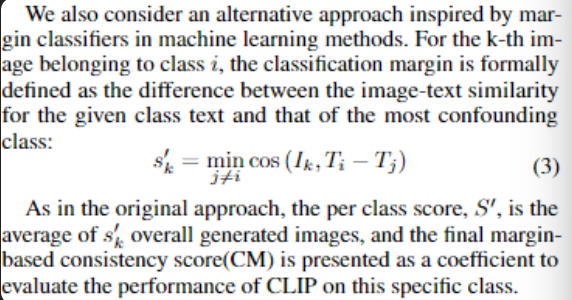

In [ ]:
import numpy as np

def calculate_classification_margin(image_embedding, text_embedding, other_class_embeddings):
    """
    Calculate the classification margin for an image in a particular class.
    
    Args:
        image_embedding (np.array): The embedding of the image.
        class_text_embedding (np.array): The embedding of the correct class text.
        other_class_embeddings (list of np.array): A list of embeddings for other class texts.
        
    Returns:
        float: The classification margin s_k' for the image in this class.
    """
    # Cosine similarity with the correct class text
    sim_correct_class =  torch.nn.functional.cosine_similarity(image_embedding.reshape(1, -1), text_embedding.reshape(1, -1)).item()
    
    # Cosine similarities with all other class texts
    sim_other_classes = [ torch.nn.functional.cosine_similarity(image_embedding.reshape(1, -1), emb.reshape(1, -1)).item() for emb in other_class_embeddings]
    
    # Find the maximum similarity with any confounding class
    sim_confounding_class = max(sim_other_classes)
    
    # Classification margin
    s_k_prime = sim_correct_class - sim_confounding_class
    return s_k_prime

def calculate_per_class_classification_margin(image_embeddings, text_embeddings, target_class):
    """
    Calculate the per-class score S' for a set of images in a particular class.
    
    Args:
        image_embeddings (list of np.array): A list of image embeddings for the class.
        class_text_embedding (np.array): The embedding of the correct class text.
        other_class_embeddings (list of np.array): A list of embeddings for other class texts.
        
    Returns:
        float: The per-class score S' for this class.
    """
    target_text_embedding = text_embeddings[target_class]
    other_class_embeddings = [embedding for class_name, embedding in text_embeddings.items() if class_name != target_class]
    # Calculate classification margin for each image in the class
    margins = [calculate_classification_margin(img_emb, target_text_embedding, other_class_embeddings) for img_emb in image_embeddings]
    
    # Average margin for all images in this class
    per_class_score = np.mean(margins)
    return per_class_score

## Run full evaluation

In [ ]:
results = []

selected_image_embeddings = generated_image_embeddings if USE_GENERATED else image_embeddings

num = 0
print(text_embeddings.keys())
for class_name in label_to_class.values():
    consistency_score = calculate_consistency_score(selected_image_embeddings, class_means, text_embeddings, class_name)
    # classification_margin = calculate_per_class_classification_margin(selected_image_embeddings[class_name], text_embeddings, class_name)
    zero_shot_accuracy = calculate_zero_shot_accuracy(class_name, selected_image_embeddings)
    print('------------------------------------------------------')
    results.append((consistency_score, 0, zero_shot_accuracy))
    # num += 1
    # if num > 20:
    #     break

## Save results and plot

In [ ]:
import pandas as pd
import os

# Prepare data for saving
data = []
for class_name, (consistency_score, classification_margin, zero_shot_accuracy) in zip(label_to_class.values(), results):
    data.append({
        'class_name': class_name,
        'consistency_score': consistency_score,
        'classification_margin': classification_margin,
        'zero_shot_accuracy': zero_shot_accuracy
    })

# Convert data to DataFrame and save as CSV
df = pd.DataFrame(data)
df.to_csv(os.path.join('.', 'results', f'{model_name}_{dataset_name}_{generation_tool if USE_GENERATED else "real"}.csv'), index=False)

In [ ]:
from scipy.stats import spearmanr, kendalltau

plt.figure(figsize=(10, 6))
plt.ylim(0.0, 1)
plt.xlim(0, 0.5)
consistency_scores, classification_margin, zero_shot_accuracies = zip(*results)
for i, class_name in enumerate(label_to_class.values()):
    plt.annotate(class_name, (consistency_scores[i], zero_shot_accuracies[i]), fontsize=8, ha='right')
plt.xlabel("Consistency Score")
plt.ylabel("Zero-Shot Accuracy")
correlation_real, _ = kendalltau(consistency_scores, zero_shot_accuracies)
print(correlation_real)

plt.title("Zero-Shot Accuracy vs. Consistency Score for Each Class")
plt.show()

plt.figure(figsize=(10, 6))
consistency_scores, classification_margin, zero_shot_accuracies = zip(*results)
for i, class_name in enumerate(label_to_class.values()):
    plt.annotate(class_name, (classification_margin[i], zero_shot_accuracies[i]), fontsize=8, ha='right')
plt.xlabel("Classification Margin")
plt.ylabel("Zero-Shot Accuracy")
plt.ylim(0, 1)
plt.xlim(-0.1, 0.1)
plt.title("Zero-Shot Accuracy vs. Consistency Score for Each Class")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.stats import spearmanr

dir_names     = ['top1', 'top3', 'top5', 'top10', 'top20', 'top50', 'top100']
dataset_names = ['cub', 'cifar', 'aircraft', 'resisc', 'flowers', 'pets', 'objectnet', 'sun', 'cars', 'food']
model_name    = 'clip'

# 1) Collect correlations
all_zs   = {}  # zero-shot correlations
all_comp = {}  # compound-score correlations

for name in dataset_names:
    zs_list   = []
    comp_list = []
    for d in dir_names:
        # load real vs generated
        real_fp = os.path.join('.', 'results', d, f'{model_name}_{name}_real.csv')
        gen_fp  = os.path.join('.', 'results', d, f'{model_name}_{name}_sdxl.csv')
        df_real = pd.read_csv(real_fp)
        df_gen  = (pd.read_csv(gen_fp)
                     .rename(columns={
                         'consistency_score':    'gen_consistency_score',
                         'zero_shot_accuracy':   'gen_zero_shot_accuracy',
                         'consistency_score2':   'gen_consistency_score2',
                         'classification_margin':'gen_classification_margin'
                     }))
        # merge
        dfm = pd.merge(df_real, df_gen, on='class_name', how='inner')

        # compute ρ for zero-shot
        rho_zs, _   = spearmanr(dfm['gen_zero_shot_accuracy'], 
                                 dfm['zero_shot_accuracy'])
        # compute ρ for your “compound” score
        compound   = dfm['gen_consistency_score'] + 4*dfm['gen_classification_margin']
        rho_comp, _ = spearmanr(compound, dfm['zero_shot_accuracy'])

        zs_list.append(rho_zs)
        comp_list.append(rho_comp)

    all_zs[name]   = zs_list
    all_comp[name] = comp_list

x = np.arange(len(dir_names))


# 2) Plot 1: Zero‐Shot Correlations
plt.figure(figsize=(16,5))
for name, zs_list in all_zs.items():
    plt.plot(x, zs_list, marker='o', linestyle='-', label=name)
plt.xticks(x, dir_names, rotation=45)
plt.xlabel('Result Directory')
plt.ylabel('Spearman ρ (Zero‐Shot)')
plt.title(f'Zero‐Shot Correlations across top-k ({model_name.upper()})')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(16,5))
for name, comp_list in all_comp.items():
    plt.plot(x, comp_list, marker='o', linestyle='-', label=name)
plt.xticks(x, dir_names, rotation=45)
plt.xlabel('Result Directory')
plt.ylabel('Spearman ρ (Zero‐Shot)')
plt.title(f'Compound Score Correlations with Real Zero-shot Accuracy across top-k ({model_name.upper()})')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 3) Plot 2: % Change from Zero-Shot → Compound
plt.figure(figsize=(16,5))
for name in dataset_names:
    zs   = np.array(all_zs[name])
    comp = np.array(all_comp[name])
    # safe % change: (comp – zs)/|zs| * 100, nan where zs==0
    pct = (comp - zs) / np.where(zs!=0, np.abs(zs), np.nan) * 100
    plt.plot(x, pct, marker='o', linestyle='--', label=name)

plt.axhline(0, color='gray', linewidth=1)
plt.xticks(x, dir_names, rotation=45)
plt.xlabel('Result Directory')
plt.ylabel('% Change (Compound vs Zero‐Shot)')
plt.title(f'Percent Change in ρ: Compound – Zero‐Shot ({model_name.upper()})')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# 1) List all the dataset names you want to process
dataset_names = [
    # 'cub',
    'cars',
    'flowers',
    'resisc',
    'pets',
    'cifar',
    # 'aircraft',
    # 'food',
    'imagenet',
    # 'objectnet'
]

generation_tool = 'sdxl'
model_name = 'clip'

# ─── 2) Build a master list of “records” (one record per class per dataset per type) ───
records = []
for ds in dataset_names:
    # Paths to your “real” and “sdxl” CSVs for this dataset
    real_fp = os.path.join(
        '.', 'results', 'FinalCLIPSDXLCaptions',
        f'{model_name}_{ds}_real.csv'
    )
    sdxl_fp = os.path.join(
        '.', 'results', 'FinalCLIPSDXLCaptions',
        f'{model_name}_{ds}_sdxl.csv'
    )

    # Skip if CSV not found
    if not os.path.exists(real_fp) or not os.path.exists(sdxl_fp):
        print(f"⚠️  Skipping dataset '{ds}': one or both CSVs not found.")
        continue

    # Load “real” CSV
    csv_real = pd.read_csv(real_fp)
    # Load “sdxl” CSV and rename generated‐image columns
    csv_sdxl = (
        pd.read_csv(sdxl_fp)
          .rename(columns={
              'consistency_score':     'gen_consistency_score',
              'zero_shot_accuracy':    'gen_zero_shot_accuracy',
              'consistency_score2':    'gen_consistency_score2',
              'classification_margin': 'gen_classification_margin'
          })
    )

    # Merge on class_name
    df = pd.merge(
        csv_real,
        csv_sdxl,
        on='class_name',
        how='inner'
    )

    # Compute “compound scores” for both “sdxl” versions
    # (you can remove the “2” variants if you don’t need them)
    df['gen_compound']  = df['gen_consistency_score']  + 4.0 * df['gen_classification_margin']
    df['gen_compound2'] = df['gen_consistency_score2'] + 4.0 * df['gen_classification_margin']

    # For every row (i.e. every class), create a single “record” for the SDXL compound score:
    for _, row in df.iterrows():
        class_name = row['class_name']
        acc_real   = row['zero_shot_accuracy']
        records.append({
            'dataset':            ds,
            'class_name':         class_name,
            'which':              'sdxl',
            'compound':           row['gen_compound'],
            'zero_shot_accuracy': acc_real
        })
        # If you want to include the “new” variant too, uncomment this block:
        # records.append({
        #     'dataset':            ds,
        #     'class_name':         class_name,
        #     'which':              'sdxl2',
        #     'compound':           row['gen_compound2'],
        #     'zero_shot_accuracy': acc_real
        # })

# Turn records into a single DataFrame
master_df = pd.DataFrame(records)

# ─── 3) Compute overall Spearman correlation and R² ────────────
df_sdxl = master_df[master_df['which'] == 'sdxl']

# 3a) Spearman rank‐order correlation
ρ_sdxl = spearmanr(df_sdxl['compound'], df_sdxl['zero_shot_accuracy']).correlation

# 3b) Pearson correlation → R² = (Pearson r)²
r_sdxl, _ = pearsonr(df_sdxl['compound'], df_sdxl['zero_shot_accuracy'])
r2_sdxl  = r_sdxl ** 2

print("Overall correlations (across all datasets):")
print(f"  Spearman (sdxl compound vs accuracy): ρ = {ρ_sdxl:.3f}")
print(f"  Pearson (sdxl compound vs accuracy): r = {r_sdxl:.3f}")
print(f"  Coefficient of determination: R² = {r2_sdxl:.3f}\n")

# ─── 4) Single Scatter Plot for “sdxl” compound scores ───────────────────
plt.figure(figsize=(10, 6))

# Choose one distinct color for each dataset, e.g. tab10
cmap = plt.get_cmap("tab10")

for idx, ds in enumerate(dataset_names):
    sub_sdxl = master_df[
        (master_df['dataset'] == ds) &
        (master_df['which'] == 'sdxl')
    ]

    color = cmap(idx % 10)  # cycle through 10 colors if >10 datasets

    # Plot “sdxl” points as circles
    plt.scatter(
        sub_sdxl['compound'],
        sub_sdxl['zero_shot_accuracy'],
        label=f"{ds}",
        marker='o',
        s=25,
        color=color,
        alpha=0.8
    )

# (Optional) Annotate only high‐compound points
for _, row in master_df.iterrows():
    if row['compound'] > 0.8:
        plt.annotate(
            '',
            (row['compound'], row['zero_shot_accuracy']),
            xytext=(3, 3),
            textcoords='offset points',
            fontsize=6,
            alpha=0.7
        )

plt.xlabel('Compound Score')
plt.ylabel('Zero‐Shot Accuracy (Real)')
plt.title(
    f"{model_name.upper()} — All Datasets (SDXL Compound Scores)\n"
    f"Spearman ρ = {ρ_sdxl:.2f},  R² = {r2_sdxl:.2f}"
)
plt.xlim(-0.3, 1.0)
plt.ylim(0.0, 1.0)
plt.grid(alpha=0.2)

# Place legend outside to avoid overlap
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
import json
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# ─── Load table.json ─────────────────────────────────────────────
with open('table.json', 'r') as f:
    table_data = json.load(f)

cs_scores = np.array(table_data['cs_score'])
res_vals  = np.array(table_data['res'])

# ─── Helper: map arbitrary x → nearest cs_score → res ────────
def map_to_nearest(cs_grid, res_grid, x_array):
    cs = np.asarray(cs_grid)
    rs = np.asarray(res_grid)
    diffs = np.abs(cs[None, :] - x_array[:, None])
    idx   = np.argmin(diffs, axis=1)
    return rs[idx]

# ─── Read CSVs, compute gen_compound and collect data ────────
dataset_names = [
    'cub', 'cars', 'flowers', 'resisc', 'pets',
    'aircraft', 'food', 'cifar'
]
model_name = 'clip'
generation_tool = 'sdxl'

all_compound = []
all_zero_acc = []
all_datasets = []

for ds in dataset_names:
    real_fp = os.path.join(
        '.', 'results', 'FinalCLIPSDXLCaptions', 
        f'{model_name}_{ds}_real.csv'
    )
    sdxl_fp = os.path.join(
        '.', 'results', 'FinalCLIPSDXLCaptions', 
        f'{model_name}_{ds}_sdxl.csv'
    )
    if not os.path.exists(real_fp) or not os.path.exists(sdxl_fp):
        print(f"Skipping {ds}: CSV missing")
        continue

    # Build map: class_name -> zero_shot_accuracy (from real CSV)
    real_map = {}
    with open(real_fp, newline='') as rf:
        reader = csv.DictReader(rf)
        for row in reader:
            real_map[row['class_name']] = float(row['zero_shot_accuracy'])

    # Read sdxl CSV: compute gen_compound for classes in real_map
    with open(sdxl_fp, newline='') as sf:
        reader = csv.DictReader(sf)
        for row in reader:
            cname = row['class_name']
            if cname not in real_map:
                continue
            gen_cons = float(row['consistency_score'])
            gen_margin = float(row['classification_margin'])
            compound = gen_cons + 4.0 * gen_margin
            zero_acc = real_map[cname]
            all_compound.append(compound)
            all_zero_acc.append(zero_acc)
            all_datasets.append(ds)

all_compound = np.array(all_compound)
all_zero_acc = np.array(all_zero_acc)

# ─── Map compound → predicted accuracy via nearest cs_score → res ─────
predicted_acc = map_to_nearest(cs_scores, res_vals, all_compound)

# ─── Compute Spearman and R² ────────────────────────────────────
rho, _     = spearmanr(predicted_acc, all_zero_acc)
pearson_r, _ = pearsonr(predicted_acc, all_zero_acc)
r2         = pearson_r ** 2

print("Overall correlations:")
print(f"  Spearman ρ = {rho:.3f}")
print(f"  Pearson r = {pearson_r:.3f},  R² = {r2:.3f}")

# ─── Plot: Predicted vs. Real Zero‐Shot Accuracy ────────────────
plt.figure(figsize=(12, 7))
cmap = plt.get_cmap("tab10")

for idx, ds in enumerate(dataset_names):
    mask = np.array(all_datasets) == ds
    plt.scatter(
        predicted_acc[mask],
        all_zero_acc[mask],
        label=ds,
        color=cmap(idx % 10),
        alpha=0.7,
        s=30
    )

plt.xlabel('Predicted Accuracy (from compound)')
plt.ylabel('Zero‐Shot Accuracy (Real)')
plt.title(
    f"{model_name.upper()} — All Datasets\n"
    f"Spearman ρ = {rho:.2f},  R² = {r2:.2f}"
)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.stats import spearmanr

dir_names = ['gen_images1', 'gen_images3', 'gen_images5', 'gen_images10', 'gen_images20']


dataset_names = ['cub', 'cifar', 'aircraft', 'resisc', 'flowers', 'pets', 'objectnet', 'sun', 'cars', 'food']
generation_tool = 'sdxl'
model_name = 'clip'

all_zs   = {}  # zero-shot correlations
all_comp = {}  # compound-score correlations

for name in dataset_names:
    zs_list   = []
    comp_list = []
    for d in dir_names:
        # load real vs generated
        real_fp = os.path.join('.', 'results', d, f'{model_name}_{name}_real.csv')
        gen_fp  = os.path.join('.', 'results', d, f'{model_name}_{name}_sdxl.csv')
        df_real = pd.read_csv(real_fp)
        df_gen  = (pd.read_csv(gen_fp)
                     .rename(columns={
                         'consistency_score':    'gen_consistency_score',
                         'zero_shot_accuracy':   'gen_zero_shot_accuracy',
                         'consistency_score2':   'gen_consistency_score2',
                         'classification_margin':'gen_classification_margin'
                     }))
        # merge
        dfm = pd.merge(df_real, df_gen, on='class_name', how='inner')

        # compute ρ for zero-shot
        rho_zs, _   = spearmanr(dfm['gen_zero_shot_accuracy'], 
                                 dfm['zero_shot_accuracy'])
        # compute ρ for your “compound” score
        compound   = dfm['gen_consistency_score'] + 4*dfm['gen_classification_margin']
        rho_comp, _ = spearmanr(compound, dfm['zero_shot_accuracy'])

        zs_list.append(rho_zs)
        comp_list.append(rho_comp)

    all_zs[name]   = zs_list
    all_comp[name] = comp_list

x = np.arange(len(dir_names))


# 2) Plot 1: Zero‐Shot Correlations
plt.figure(figsize=(16,5))
for name, zs_list in all_zs.items():
    plt.plot(x, zs_list, marker='o', linestyle='-', label=name)
plt.xticks(x, dir_names, rotation=45)
plt.xlabel('Result Directory')
plt.ylabel('Spearman ρ (Zero‐Shot)')
plt.title(f'Zero‐Shot Correlations across top-k ({model_name.upper()})')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
for name, comp_list in all_comp.items():
    plt.plot(x, comp_list, marker='o', linestyle='-', label=name)
plt.xticks(x, dir_names, rotation=45)
plt.xlabel('Result Directory')
plt.ylabel('Spearman ρ (Zero‐Shot)')
plt.title(f'Compound Score Correlations with Real Zero-shot Accuracy across top-k ({model_name.upper()})')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 3) Plot 2: % Change from Zero-Shot → Compound
plt.figure(figsize=(16,5))
for name in dataset_names:
    zs   = np.array(all_zs[name])
    comp = np.array(all_comp[name])
    # safe % change: (comp – zs)/|zs| * 100, nan where zs==0
    pct = (comp - zs) / np.where(zs!=0, np.abs(zs), np.nan) * 100
    plt.plot(x, pct, marker='o', linestyle='--', label=name)

plt.axhline(0, color='gray', linewidth=1)
plt.xticks(x, dir_names, rotation=45)
plt.xlabel('Result Directory')
plt.ylabel('% Change (Compound vs Zero‐Shot)')
plt.title(f'Percent Change in ρ: Compound – Zero‐Shot ({model_name.upper()})')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import numpy as np
from scipy.stats import spearmanr

dataset_name = 'resisc'
generation_tool = 'sdxl'
model_name = 'flava'

# Load CSV files
csv_real = pd.read_csv(os.path.join('.', 'results', 'FinalFlavaSDXLCaptions', f'{model_name}_{dataset_name}_real.csv'))
# csv_dalle = pd.read_csv(os.path.join('.', 'results', 'extraDatasets', f'{model_name}_{dataset_name}_dalle3.csv'))
csv_sdxl = pd.read_csv(os.path.join('.', 'results', 'FinalFlavaSDXLCaptions', f'{model_name}_{dataset_name}_sdxl.csv'))
csv_sdxl = csv_sdxl.rename(columns={
    'consistency_score': 'gen_consistency_score',
    'zero_shot_accuracy': 'gen_zero_shot_accuracy',
    'consistency_score2': 'gen_consistency_score2',
    'classification_margin': 'gen_classification_margin'
})
# csv_sdxl = csv_dalle
colors = plt.cm.get_cmap("tab10")
df_merged = pd.merge(
    csv_real, 
    csv_sdxl, 
    on='class_name',
    how='inner'
)

# df_filtered = df_merged[
#     (df_merged['zero_shot_accuracy'] != 0) &
#     (df_merged['zero_shot_accuracy'] != 1) &
#     (df_merged['gen_zero_shot_accuracy'] != 0) &
#     (df_merged['gen_zero_shot_accuracy'] != 1)
# ].copy()
df_filtered = df_merged.copy()

# Extract columns
real_zero_shot = df_filtered['zero_shot_accuracy']
real_class_name = csv_real['class_name']
print('avg accuracy:', np.mean(real_zero_shot))
print('avg compactness sdxl:', np.mean(csv_sdxl['compactness']))
print('avg compactness real:', np.mean(csv_real['compactness']))


# normalized_consistency_score_real = (df_filtered['consistency_score'] - df_filtered['consistency_score'].mean()) / df_filtered['consistency_score'].std()
# normalized_consistency_score_sdxl = (df_filtered['gen_consistency_score'] - df_filtered['gen_consistency_score'].mean()) / df_filtered['gen_consistency_score'].std()
# normalized_consistency_score_dalle = (csv_dalle['consistency_score'] - csv_dalle['consistency_score'].mean()) / csv_dalle['consistency_score'].std()

# Ensure that the rows align by 'class name' for a fair comparison
# csv_dalle = csv_dalle[csv_dalle['class_name'].isin(real_class_name)].set_index('class_name').reindex(real_class_name)
# csv_sdxl = csv_sdxl[csv_sdxl['class_name'].isin(real_class_name)].set_index('class_name').reindex(real_class_name)

# First Plot: y = zero-shot accuracy from "real" csv, x = consistency score from other csvs
plt.figure(figsize=(10, 6))
correlation_real, _ = spearmanr(df_filtered['consistency_score'] + (0 * df_filtered['classification_margin']), real_zero_shot)
# correlation_dalle3, _ = spearmanr(csv_dalle['consistency_score'], real_zero_shot)
correlation_sdxl, _ = spearmanr(df_filtered['gen_consistency_score'] + (0 * df_filtered['gen_classification_margin']), real_zero_shot)
plt.annotate(f'Model name: {model_name.upper()}, Dataset: {dataset_name}', xy=(0.05, 1.25 + 0.04 * 4), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for real images: {correlation_real:.2f}', xy=(0.05, 1.25 + 0.04 * 1), xycoords='axes fraction', fontsize=10, ha='left', va='top')
# plt.annotate(f'Spearman Rank Correlation for DALLE3 images: {correlation_dalle3:.2f}', xy=(0.05, 1.25 + 0.04 * 2), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for SDXL images: {correlation_sdxl:.2f}', xy=(0.05, 1.25 + 0.04 * 3), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.scatter(df_filtered['consistency_score'] + (0 * df_filtered['classification_margin']), real_zero_shot, label="Real", alpha=0.7, color=colors(0))
# plt.scatter(csv_dalle['consistency_score'], real_zero_shot, label="DALLE3", alpha=0.7, color=colors(1))
plt.scatter(df_filtered['gen_consistency_score'] + (0 * df_filtered['gen_classification_margin']), real_zero_shot, label="SDXL", alpha=0.7, color=colors(2))
for i in range(len(df_merged)):
    class_label = df_merged['class_name'].iloc[i]
    # (Optionally offset the text slightly so it doesn’t overlap the marker)
    plt.annotate(
        class_label,
        (df_filtered['gen_consistency_score'].iloc[i], real_zero_shot[i]),
        xytext=(3, 3),  # offset (x=3, y=3) pixels
        textcoords='offset points',
        fontsize=8
    )
plt.xlabel('Consistency Score')
plt.ylabel('Zero-Shot Accuracy (Real)')
plt.title('Zero-Shot Accuracy vs. Consistency Score')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
correlation_real, _ = spearmanr(df_filtered['consistency_score'] + (4 * df_filtered['classification_margin']), real_zero_shot)
# correlation_dalle3, _ = spearmanr(csv_dalle['consistency_score'], real_zero_shot)
correlation_sdxl, _ = spearmanr(df_filtered['gen_consistency_score'] + (4 * df_filtered['gen_classification_margin']), real_zero_shot)
# plt.annotate(f'Model name: {model_name.upper()}, Dataset: {dataset_name}', xy=(0.05, 1.25 + 0.04 * 4), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for real images: {correlation_real:.2f}', xy=(0.05, 1.25 + 0.04 * 1), xycoords='axes fraction', fontsize=10, ha='left', va='top')
# plt.annotate(f'Spearman Rank Correlation for DALLE3 images: {correlation_dalle3:.2f}', xy=(0.05, 1.25 + 0.04 * 2), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for SDXL images: {correlation_sdxl:.2f}', xy=(0.05, 1.25 + 0.04 * 3), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.scatter(df_filtered['consistency_score'] + (4 * df_filtered['classification_margin']), real_zero_shot, label="Real", alpha=0.7, color=colors(0))
# plt.scatter(csv_dalle['consistency_score'], real_zero_shot, label="DALLE3", alpha=0.7, color=colors(1))
plt.scatter(df_filtered['gen_consistency_score'] + (4 * df_filtered['gen_classification_margin']), real_zero_shot, label="SDXL", alpha=0.7, color=colors(2))
for i in range(len(df_merged)):
    class_label = df_merged['class_name'].iloc[i]
    # (Optionally offset the text slightly so it doesn’t overlap the marker)
    plt.annotate(
        class_label,
        (df_filtered['gen_consistency_score'].iloc[i]  + (4 * df_filtered['gen_classification_margin'].iloc[i]), real_zero_shot[i]),
        xytext=(3, 4),  # offset (x=3, y=3) pixels
        textcoords='offset points',
        fontsize=8
    )
plt.xlim(-0.3, 0.9)
plt.xlabel('Compound Score')
plt.ylabel('Zero-Shot Accuracy (Real)')
plt.title('Zero-Shot Accuracy vs. Consistency Score')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
correlation2_real, _ = spearmanr(df_filtered['consistency_score2'] + (4 * df_filtered['classification_margin']), real_zero_shot)
# correlation2_dalle3, _ = spearmanr(csv_dalle['consistency_score2'], real_zero_shot)
correlation2_sdxl, _ = spearmanr(df_filtered['gen_consistency_score2'] + (4 * df_filtered['gen_classification_margin']), real_zero_shot)
plt.annotate(f'Model name: {model_name.upper()}, Dataset: {dataset_name}', xy=(0.05, 1.25 + 0.04 * 4), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for real images (new): {correlation2_real:.2f}', xy=(0.05, 1.25 + 0.04 * 5), xycoords='axes fraction', fontsize=10, ha='left', va='top')
# plt.annotate(f'Spearman Rank Correlation for DALLE3 images (new): {correlation2_dalle3:.2f}', xy=(0.05, 1.25 + 0.04 * 6), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for SDXL images (new): {correlation2_sdxl:.2f}', xy=(0.05, 1.25 + 0.04 * 7), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.scatter(df_filtered['consistency_score2'] + (4 * df_filtered['classification_margin']), real_zero_shot, label="Real", alpha=0.7, color=colors(0))
# plt.scatter(csv_dalle['consistency_score2'], real_zero_shot, label="DALLE3", alpha=0.7, color=colors(1))
plt.scatter(df_filtered['gen_consistency_score2'] + (4 * df_filtered['gen_classification_margin']), real_zero_shot, label="SDXL", alpha=0.7, color=colors(2))
for i in range(len(df_filtered)):
    class_label = df_merged['class_name'].iloc[i]
    plt.annotate(
        class_label,
        (df_filtered['consistency_score2'].iloc[i]  + (4 * df_filtered['classification_margin'].iloc[i]), real_zero_shot[i]),
        xytext=(3, 3),  # offset (x=3, y=3) pixels
        textcoords='offset points',
        fontsize=8
    )
plt.xlabel('Compound Weighted Consistency Score')
plt.ylabel('Zero-Shot Accuracy (Real)')
plt.title('Zero-Shot Accuracy vs. Consistency Score (weighted)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
correlation2_real, _ = spearmanr(csv_real['compactness'], real_zero_shot)
# correlation2_dalle3, _ = spearmanr(csv_dalle['consistency_score2'], real_zero_shot)
correlation2_sdxl, _ = spearmanr(csv_sdxl['compactness'], real_zero_shot)
plt.annotate(f'Model name: {model_name.upper()}, Dataset: {dataset_name}', xy=(0.05, 1.25 + 0.04 * 4), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for real images (new): {correlation2_real:.2f}', xy=(0.05, 1.25 + 0.04 * 5), xycoords='axes fraction', fontsize=10, ha='left', va='top')
# plt.annotate(f'Spearman Rank Correlation for DALLE3 images (new): {correlation2_dalle3:.2f}', xy=(0.05, 1.25 + 0.04 * 6), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for SDXL images (new): {correlation2_sdxl:.2f}', xy=(0.05, 1.25 + 0.04 * 7), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.scatter(csv_real['compactness'], real_zero_shot, label="Real", alpha=0.7, color=colors(0))
# plt.scatter(csv_dalle['consistency_score2'], real_zero_shot, label="DALLE3", alpha=0.7, color=colors(1))
plt.scatter(csv_sdxl['compactness'], real_zero_shot, label="SDXL", alpha=0.7, color=colors(2))
plt.xlabel('Consistency Score')
plt.ylabel('Zero-Shot Accuracy (Real)')
plt.title('Zero-Shot Accuracy vs. silhouette score for class / compactness sometimes')
plt.legend()
plt.show()



plt.figure(figsize=(10, 6))
correlation_real, _ = spearmanr(df_filtered['classification_margin'], real_zero_shot)
# correlation_dalle3, _ = spearmanr(csv_dalle['classification_margin'], real_zero_shot)
correlation_sdxl, _ = spearmanr(df_filtered['gen_classification_margin'], real_zero_shot)
plt.annotate(f'Model name: {model_name.upper()}, Dataset: {dataset_name}', xy=(0.05, 1.25 + 0.04 * 4), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for real images: {correlation_real:.2f}', xy=(0.05, 1.25 + 0.04 * 1), xycoords='axes fraction', fontsize=10, ha='left', va='top')
# plt.annotate(f'Spearman Rank Correlation for DALLE3 images: {correlation_dalle3:.2f}', xy=(0.05, 1.25 + 0.04 * 2), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for SDXL images: {correlation_sdxl:.2f}', xy=(0.05, 1.25 + 0.04 * 3), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.scatter(df_filtered['classification_margin'], real_zero_shot, label="Real", alpha=0.7, color=colors(0))
# plt.scatter(csv_dalle['classification_margin'], real_zero_shot, label="DALLE3", alpha=0.7, color=colors(1))
plt.scatter(df_filtered['gen_classification_margin'], real_zero_shot, label="SDXL", alpha=0.7, color=colors(2))
plt.xlabel('Classification Margin')
plt.ylabel('Zero-Shot Accuracy (Real)')
plt.title('Zero-Shot Accuracy vs. Classification Margin')
plt.legend()
plt.show()

# Second Plot: y = zero-shot accuracy from "real" csv, x = zero-shot accuracy from other csvs
plt.figure(figsize=(10, 6))
# correlation_dalle3, _ = spearmanr(csv_dalle['zero_shot_accuracy'], real_zero_shot)
correlation_sdxl, _ = spearmanr(df_filtered['gen_zero_shot_accuracy'], real_zero_shot)
plt.annotate(f'Model name: {model_name.upper()}, Dataset: {dataset_name}', xy=(0.05, 1.25 + 0.04 * 4), xycoords='axes fraction', fontsize=10, ha='left', va='top')
# plt.annotate(f'Spearman Rank Correlation for DALLE3 images: {correlation_dalle3:.2f}', xy=(0.05, 1.25 + 0.04 * 2), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for SDXL images: {correlation_sdxl:.2f}', xy=(0.05, 1.25 + 0.04 * 3), xycoords='axes fraction', fontsize=10, ha='left', va='top')
# plt.scatter(csv_dalle['zero_shot_accuracy'], real_zero_shot, label="DALLE3", alpha=0.7, color=colors(1))
plt.scatter(df_filtered['gen_zero_shot_accuracy'], real_zero_shot, label="SDXL", alpha=0.7, color=colors(2))
plt.xlabel('Zero-Shot Accuracy (Generated)')
plt.ylabel('Zero-Shot Accuracy (Real)')
plt.title('Zero-Shot Accuracy vs. Zero-Shot Accuracy (Real vs. Generated)')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
# correlation_dalle3, _ = spearmanr(csv_dalle['consistency_score'], csv_dalle['zero_shot_accuracy'])
correlation_sdxl, _ = spearmanr(df_filtered['gen_consistency_score'], df_filtered['gen_zero_shot_accuracy'])
plt.annotate(f'Model name: {model_name.upper()}, Dataset: {dataset_name}', xy=(0.05, 1.25 + 0.04 * 4), xycoords='axes fraction', fontsize=10, ha='left', va='top')
# plt.annotate(f'Spearman Rank Correlation for DALLE3 images: {correlation_dalle3:.2f}', xy=(0.05, 1.25 + 0.04 * 2), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for SDXL images: {correlation_sdxl:.2f}', xy=(0.05, 1.25 + 0.04 * 3), xycoords='axes fraction', fontsize=10, ha='left', va='top')

# plt.scatter(csv_dalle['consistency_score'], csv_dalle['zero_shot_accuracy'], label="DALLE3", alpha=0.7, color=colors(1))
plt.scatter(df_filtered['gen_consistency_score'], df_filtered['gen_zero_shot_accuracy'], label="SDXL", alpha=0.7, color=colors(2))
plt.xlabel('Consistency Score')
plt.ylabel('Zero-Shot Accuracy (Generated)')
plt.title('Consistency Score vs. Zero-Shot Accuracy')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
# correlation_dalle3, _ = spearmanr(csv_dalle['classification_margin'], csv_dalle['zero_shot_accuracy'])
correlation_sdxl, _ = spearmanr(df_filtered['gen_classification_margin'], df_filtered['gen_zero_shot_accuracy'])
plt.annotate(f'Model name: {model_name.upper()}, Dataset: {dataset_name}', xy=(0.05, 1.25 + 0.04 * 4), xycoords='axes fraction', fontsize=10, ha='left', va='top')
# plt.annotate(f'Spearman Rank Correlation for DALLE3 images: {correlation_dalle3:.2f}', xy=(0.05, 1.25 + 0.04 * 2), xycoords='axes fraction', fontsize=10, ha='left', va='top')
plt.annotate(f'Spearman Rank Correlation for SDXL images: {correlation_sdxl:.2f}', xy=(0.05, 1.25 + 0.04 * 3), xycoords='axes fraction', fontsize=10, ha='left', va='top')

# plt.scatter(csv_dalle['classification_margin'], csv_dalle['zero_shot_accuracy'], label="DALLE3", alpha=0.7, color=colors(1))
plt.scatter(df_filtered['gen_classification_margin'], df_filtered['gen_zero_shot_accuracy'], label="SDXL", alpha=0.7, color=colors(2))
plt.xlabel('Consistency Score')
plt.ylabel('Zero-Shot Accuracy (Generated)')
plt.title('Classification Margin vs. Zero-Shot Accuracy')
plt.legend()
plt.show()

In [ ]:
from datasets import filesystems
filesystems.clear_cache()